In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from sympy import Symbol, diff, lambdify
from sklearn.linear_model import LinearRegression
from scipy import stats

# Plot settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 1

# Define SDE's

In [2]:
class SDE(ABC):
    def __init__(self, time_horizon, num_steps, x0):
        # time discretization
        self.T = time_horizon
        self.N = num_steps
        self.dt = time_horizon / num_steps
        self.ts = np.linspace(0, time_horizon, num_steps)[:, None]  # add second dimension for num_simulations broadcasting
        
        # initial value
        self.x0 = x0
    
    @abstractmethod
    def drift(self, X_t, t):
        """
        Abstract method for drift coefficient
        :param X_t: float: current value of the process
        :param t: float: current time
        :return: float: drift coefficient
        """
        pass
    
    @abstractmethod
    def diffusion(self, X_t, t):
        """
        Abstract method for diffusion coefficient
        :param X_t: float: current value of the process
        :param t: float: current time
        :return: float: diffusion coefficient
        """
        pass
    
    @abstractmethod
    def exact_solutions(self, num_simulations=1, seed=None):
        """
        Sample exact solution paths of the SDE
        :param num_simulations: int: number of sampled paths 
        :param seed: int: seed to get control over sampled BB
        :return: np.ndarray: Paths of shape (num_timesteps) if num_simulations=1 or (num_timesteps, num_simulations) otherwise 
        """
        pass
    
    def sample_brownian_motion(self, num_simulations=1, seed=None):
        """
        Sample random Brownian Motion with given time discretization
        :param num_simulations: int: number of sampled BBs
        :param seed: int: seed to get control over sampled BB
        :return: np.ndarray: BB paths of shape (num_timesteps, num_simulations) 
        """
        if seed is not None:
            np.random.seed(seed)
        dW = np.sqrt(self.dt) * np.random.randn(self.N, num_simulations)
        dW[0] = 0
        W = np.cumsum(dW, axis=0)
        return W
    
    def update_time_discretization(self, num_steps=None, dt=None, ts=None):
        """
        Update time discretization of SDE instance. Only one of num_steps, dt or ts must be specified.
        :param num_steps: int: number of time steps
        :param dt: float: time step
        :param ts: np.ndarray: time grid
        """
        if num_steps is not None:
            self.N = num_steps
            self.dt = self.T / num_steps
            self.ts = np.linspace(0, self.T, num_steps)[:, None]
        elif dt is not None:
            self.dt = dt
            self.N = int(self.T / dt)
            self.ts = np.linspace(0, self.T, self.N)[:, None]
        elif ts is not None:
            self.ts = ts.reshape(-1, 1)
            self.N = len(ts)
            self.dt = ts[1] - ts[0]
        else:
            raise ValueError("Either num_steps, dt or ts must be specified")
    
    def __repr__(self):
        """
        String representation of SDE instance
        """
        return f"{type(self).__name__}(time_horizon={self.T}, num_steps={self.N}, x0={self.x0})"

In [3]:
T = 1  # time horizon
X0 = 1  # initial value
NUM_STEPS = 1000  # number of discretization steps
SEED = 137  # random seed

### Geometric Brownian Motion

In [4]:
class GeometricBrownianMotion(SDE):
    def __init__(self, time_horizon, num_steps, x0, mu, sigma):
        super().__init__(time_horizon, num_steps, x0)
        self.mu = mu
        self.sigma = sigma
    
    def drift(self, X_t, t):
        return self.mu * X_t
    
    def diffusion(self, X_t, t):
        return self.sigma * X_t
    
    def exact_solutions(self, num_simulations=1, seed=None) -> np.ndarray:
        W = self.sample_brownian_motion(num_simulations, seed)
        X = self.x0 * np.exp((self.mu - 0.5 * self.sigma ** 2) * self.ts + self.sigma * W)
        return X.squeeze()
    
    def __repr__(self):
        return f"Geometric Brownian Motion with T={self.T}, N={self.N}, x0={self.x0}, mu={self.mu}, sigma={self.sigma}"

### Ornstein-Uhlenbeck

In [5]:
class OrnsteinUhlenbeck(SDE):
    def __init__(self, time_horizon, num_steps, x0, mu, theta, sigma):
        super().__init__(time_horizon, num_steps, x0)
        assert sigma > 0, "Assumptions on SDE parameters are not satisfied"  # should theta also be positive here?
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
    
    def drift(self, X_t, t):
        return self.theta * (self.mu - X_t)
    
    def diffusion(self, X_t, t):
        return self.sigma
    
    def exact_solutions(self, num_simulations=1, seed=None):
        W = self.sample_brownian_motion(num_simulations, seed)
        dW = np.diff(W, axis=0)
        int_term = np.array([
            np.sum([
                np.exp(-self.theta * (self.ts[i] - self.ts[j])) * dW[j] for j in range(i)
            ], axis=0) for i in range(1, self.N)
        ])
        int_term = np.insert(int_term, 0, 0, axis=0)
        X = self.x0 * np.exp(-self.theta * self.ts) + self.mu * (1 - np.exp(-self.theta * self.ts)) + self.sigma * int_term
        return X.squeeze()
    
    def __repr__(self):
        return f"Ornstein Uhlenbeck Process with T={self.T}, N={self.N}, x0={self.x0}, mu={self.mu}, theta={self.theta}, sigma={self.sigma}"

### Cox-Ingersoll-Ross

In [6]:
class CoxIngersollRoss(SDE):
    def __init__(self, time_horizon, num_steps, x0, a, b, sigma):
        super().__init__(time_horizon, num_steps, x0)
        assert a >= 0 and b >= 0 and sigma > 0, "Assumptions on SDE parameters are not satisfied"
        self.a = a
        self.b = b
        self.sigma = sigma
    
    def drift(self, X_t, t):
        return self.a - self.b * X_t
    
    def diffusion(self, X_t, t):
        X_t = np.maximum(X_t, 1e-9)  # FIXME?
        return self.sigma * (X_t ** 0.5)
    
    def diffusion_derivative(self, X_t):
        X_t = np.maximum(X_t, 1e-9)  # FIXME?
        return 0.5 * self.sigma * (X_t ** -0.5)
    
    def exact_solutions(self, num_simulations=1, seed=None):
        # TODO: find solutions for other settings
        if self.a == 1 and self.sigma == 2:
            """
            dX_t = (1 - bX_t) dt + 2 sqrt(X_t) dW_t
            https://arxiv.org/pdf/1601.01455.pdf (Proposition 1)
            """
            U = OrnsteinUhlenbeck(self.T, self.N, np.sqrt(self.x0), mu=0, theta=self.b/2, sigma=1).exact_solutions(num_simulations, seed)
            inf_inputs = [np.exp(self.b * self.ts[i] / 2) * U[i] for i in range(self.N)]
            X = np.zeros((self.N, num_simulations))
            X[0] = self.x0
            for i in range(self.N-1):
                X[i+1] = (U[i] + np.exp(-self.b * self.ts[i] / 2) * (-np.minimum(0, np.min(inf_inputs[:i+1], axis=0)))) ** 2
        elif self.a > 0 and self.sigma == 2:
            """
            dX_t = (a - bX_t) dt + 2 sqrt(X_t) dW_t
            https://arxiv.org/pdf/1608.00410.pdf (Remark 4)
            """
            # FIXME: it will not work without synchronization between sampled chi-squared and BB
            Z = stats.chi2.rvs(df=self.a, size=(self.N, num_simulations), random_state=seed)
            psi = 1 - np.exp(-self.b * self.ts) / self.b if self.b != 0 else self.ts
            X = psi * Z  # FIXME: what about X0?
            raise NotImplementedError("Exact solution not implemented yet")
        else:
            raise NotImplementedError("Exact solution is not implemented or not known")
        return X.squeeze()
    
    def __repr__(self):
        return f"Cox-Ingersoll-Ross Process with T={self.T}, N={self.N}, x0={self.x0}, a={self.a}, b={self.b}, sigma={self.sigma}"

## Choose sde

Choose SDE between one of implemented above

In [7]:
# sde = GeometricBrownianMotion(time_horizon=T, num_steps=NUM_STEPS, x0=X0, mu=2, sigma=1)
sde = CoxIngersollRoss(time_horizon=T, num_steps=NUM_STEPS, x0=X0, a=1, b=0, sigma=2)
# sde = OrnsteinUhlenbeck(time_horizon=T, num_steps=NUM_STEPS, x0=X0, mu=0, theta=1, sigma=1)

print(f'Chosen SDE: {sde}')

Chosen SDE: Cox-Ingersoll-Ross Process with T=1, N=1000, x0=1, a=1, b=0, sigma=2


## Examples of exact solutions


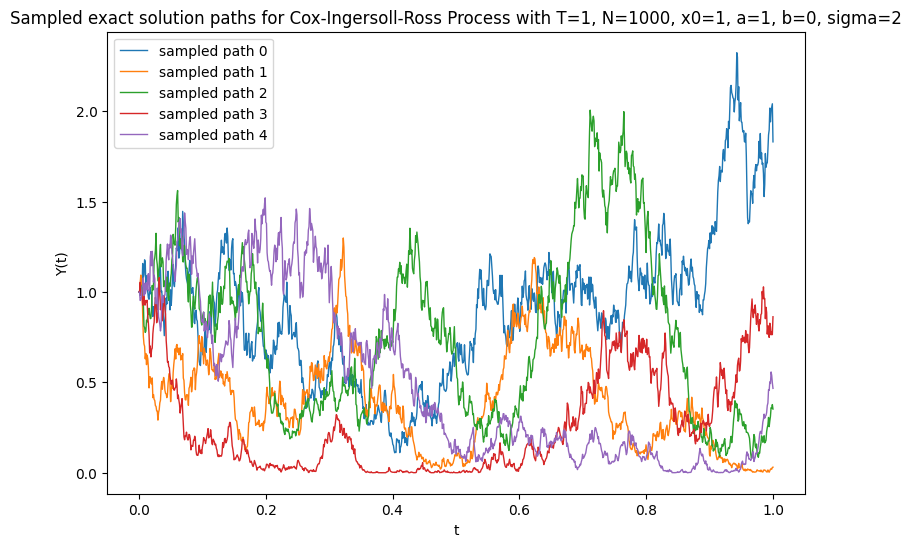

In [8]:
simulations = 5
exact_solutions = sde.exact_solutions(num_simulations=simulations)

for num in range(simulations):
    exact_solution = exact_solutions[:, num]
    plt.plot(sde.ts, exact_solution, label = "sampled path " + str(num))

plt.title(f'Sampled exact solution paths for {sde}')
plt.ylabel('Y(t)')
plt.xlabel('t')
plt.legend()

### Distribution of exact solutions of Geometric Brownian Motion with different parameters

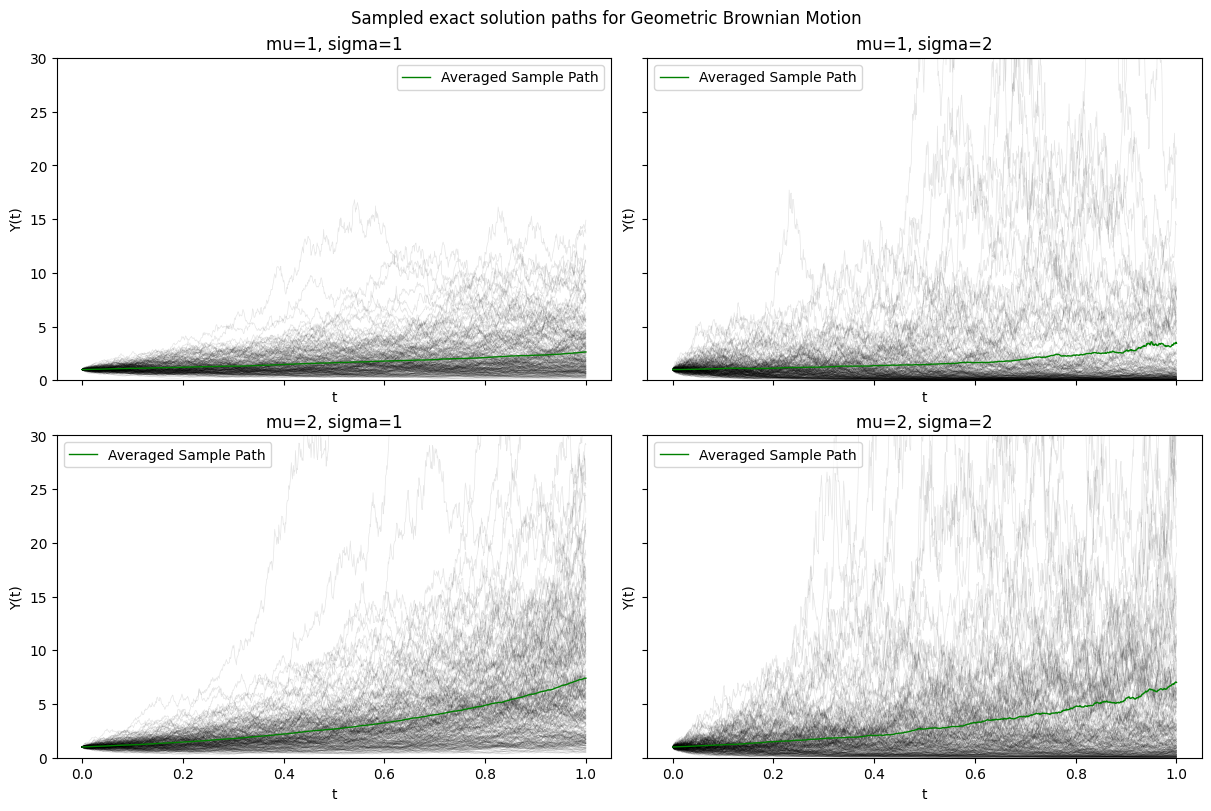

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Sampled exact solution paths for Geometric Brownian Motion')

simulations = 1000
num_plots = 250
ylim = 30 

# Exact Solutions for different parameters
mus = [1, 2]
sigmas = [1, 2]
for i in range(len(mus)):
    for j in range(len(sigmas)):
        gbm = GeometricBrownianMotion(time_horizon=T, num_steps=1000, x0=X0, mu=mus[i], sigma=sigmas[j])
        exact_solutions = gbm.exact_solutions(num_simulations=simulations)
        for k in range(num_plots):
            axs[i, j].plot(gbm.ts, exact_solutions[:, k], alpha=0.1, color='black', linewidth=0.5)
        axs[i, j].plot(gbm.ts, np.mean(exact_solutions, axis=1), label="Averaged Sample Path", color='green')
        axs[i, j].set_title(f'mu={mus[i]}, sigma={sigmas[j]}')
        axs[i, j].set_ylabel('Y(t)')
        axs[i, j].set_xlabel('t')
        axs[i, j].set_ylim(0, ylim)
        axs[i, j].legend()

## Solution approximations

We define several approximation methods for SDEs. We will use them to approximate exact solutions of SDEs and calculate convergence rates.

In [10]:
APPROXIMATION_METHODS = ['Euler-Maruyama', 'Milstein', 'Runge-Kutta']  # list of methods to use

def euler_maruyama(sde: SDE, num_simulations=1, seed=None):
    W = sde.sample_brownian_motion(num_simulations, seed)
    dW = np.diff(W, axis=0)
    X = np.zeros((sde.N, num_simulations))
    X[0] = sde.x0
    for i in range(sde.N - 1):
        X[i+1] = X[i] + sde.drift(X[i], sde.ts[i]) * sde.dt + sde.diffusion(X[i], sde.ts[i]) * dW[i]
    return X.squeeze()

def milstein(sde: SDE, num_simulations=1, seed=None):
    assert all(sde.diffusion(sde.x0, 0) == sde.diffusion(sde.x0, t) for t in sde.ts), "Milstein method requires diffusion to be independent of time"
    
    # symbolic differentiation of diffusion function
    x = Symbol('X')
    if hasattr(sde, 'diffusion_derivative'):
        diffusion_derivative = sde.diffusion_derivative
    else:
        diffusion_derivative = lambdify(x, diff(sde.diffusion(x, t=0), x), 'numpy')
    
    W = sde.sample_brownian_motion(num_simulations, seed)
    dW = np.diff(W, axis=0)
    X = np.zeros((sde.N, num_simulations))
    X[0] = sde.x0
    for i in range(sde.N - 1):
        X[i+1] = (X[i] + sde.drift(X[i], sde.ts[i]) * sde.dt + sde.diffusion(X[i], sde.ts[i]) * dW[i]
                + 0.5 * sde.diffusion(X[i], sde.ts[i]) * diffusion_derivative(X[i]) * (dW[i] ** 2 - sde.dt))
    return X.squeeze()

def runge_kutta(sde: SDE, num_simulations=1, seed=None):
    assert all(sde.drift(sde.x0, 0) == sde.drift(sde.x0, t) for t in sde.ts), "Runge-Kutta method requires drift to be independent of time"
    assert all(sde.diffusion(sde.x0, 0) == sde.diffusion(sde.x0, t) for t in sde.ts), "Runge-Kutta method requires diffusion to be independent of time"
    
    W = sde.sample_brownian_motion(num_simulations, seed)
    dW = np.diff(W, axis=0)
    X = np.zeros((sde.N, num_simulations))
    X[0] = sde.x0
    for i in range(0, sde.N-1):
        a = sde.drift(X[i], 0)
        b = sde.diffusion(X[i], 0)
        korr_X = X[i] + a * sde.dt + b * sde.dt ** 0.5
        X[i+1] = X[i] + a * sde.dt + b * dW[i] + 0.5 * (sde.diffusion(korr_X, 0) - b) * (dW[i] ** 2 - sde.dt) * (sde.dt ** -0.5)
    return X.squeeze()

def approximation_method(name: str):
    """
    Get approximation method by name
    :param name: str: name of approximation method
    :return: function: approximation method
    """
    if name == 'Euler-Maruyama':
        return euler_maruyama
    elif name == 'Milstein':
        return milstein
    elif name == 'Runge-Kutta':
        return runge_kutta
    else:
        raise NotImplementedError(f'Approximation method {name} not implemented')

Let's compare exact solution and implemented approximations. Beware, randomness of sampled path is always hidden inside used sampled BB path. So two sampled paths are comparable only if they are based on same BB.
Time discretization resolution should probably be lower to see difference.

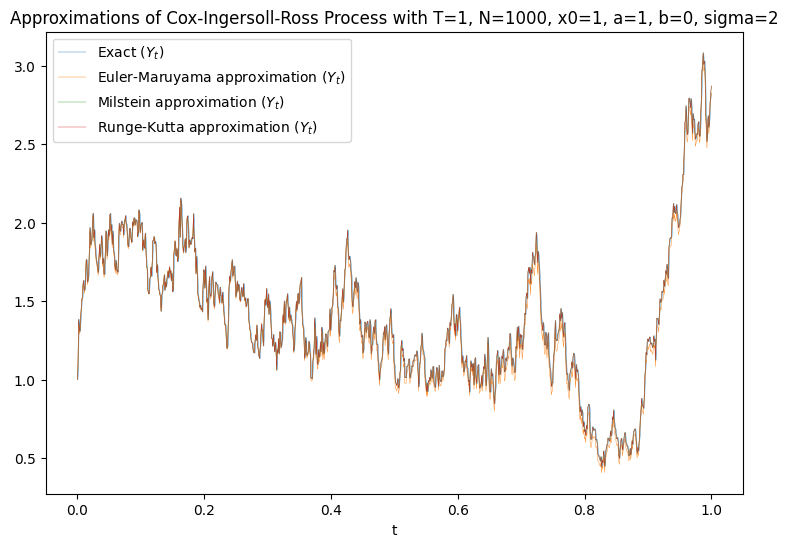

In [11]:
plt.title(f'Approximations of {sde}')

# Exact solution
exact_solution = sde.exact_solutions(num_simulations=1, seed=SEED)
plt.plot(sde.ts, exact_solution, label="Exact ($Y_t$)", linewidth=0.3)

# Approximations
for method_name in APPROXIMATION_METHODS:
    approximation = approximation_method(method_name)(sde, num_simulations=1, seed=SEED)
    plt.plot(sde.ts, approximation, label=f"{method_name} approximation ($Y_t$)", linewidth=0.3)
plt.xlabel('t')
plt.legend()

## $L^p$ errors

Now we calculate $L^p$ error for sampled solution and approximation paths.
Mathematically, strong $L^p$ error between two processes $X$ and $Y$ is defined as
$$ e(X, Y) = \sup_{t \in [0, T]} \mathbb{E} \Big[ \left| X_t - Y_t \right|^p \Big]^{1/p}\,, $$
for finite time discretization we use
$$ e_{\Delta t}(X, Y) = \max_{t \in \{t_0, t_1, \dots, t_N\}} \mathbb{E} \Big[ \left| X_t - Y_t \right|^p \Big]^{1/p}\,. $$

With Monte Carlo simulation we approximate error between exact solution and approximation as
$$ Err(\Delta t) = \max_{t \in \{t_0, t_1, \dots, t_N\}} \frac{1}{M}\sum_{i=1}^{M} \Big[ \left| X^i_t - Y^i_t \right|^p \Big]^{1/p}\,, $$
where $M$ is number of simulations and $X^i$, $Y^i$ are sampled paths (based on same BB) of exact solution and approximation respectively.

In [12]:
def calculate_error(solutions, calc_approximations, p=1):
    """
    Calculate L^p error between sampled solutions and approximations
    :param solutions: np.ndarray: exact solutions of shape (num_timesteps[, num_simulations])
    :param calc_approximations: np.ndarray: approximations of shape (num_timesteps[, num_simulations])
    :param p: float: p in L^p norm
    :return: float: strong L^p error
    """
    assert p >= 1, "p \in [1, \infty)"
    error = np.max(np.mean(np.abs(solutions - calc_approximations) ** p, axis=1) ** (1/p))
    return error

In [13]:
%%time
# Initiate dt grid and lists to store errors
p_values = (1, 2, 3)  # p in L^p norm
errors = {p: {method_name: [] for method_name in APPROXIMATION_METHODS} for p in p_values}
dt_grid = [10 ** R for R in (-4, -3, -2, -1)]
num_steps_grid = [int(sde.T / dt) for dt in dt_grid]
simulations = 10000

print(f'SDE is {sde}')
for N in num_steps_grid:
    print(f"Running simulations for N = {N}")
    # Initiate SDE
    sde.update_time_discretization(num_steps=N)
    
    # Generate many sample paths
    exact_solutions = sde.exact_solutions(num_simulations=simulations, seed=SEED)
    approximations = {
        method_name: approximation_method(method_name)(sde, simulations, seed=SEED)
        for method_name in APPROXIMATION_METHODS
    }
    
    # Calculate errors
    for p in p_values:
        for method_name in APPROXIMATION_METHODS:
            errors[p][method_name].append(
                calculate_error(exact_solutions, approximations[method_name], p=p)
            )
print("Done")

SDE is Cox-Ingersoll-Ross Process with T=1, N=1000, x0=1, a=1, b=0, sigma=2
Running simulations for N = 10000
Running simulations for N = 1000
Running simulations for N = 100
Running simulations for N = 10
Done
CPU times: user 19min 58s, sys: 8min 1s, total: 28min
Wall time: 28min


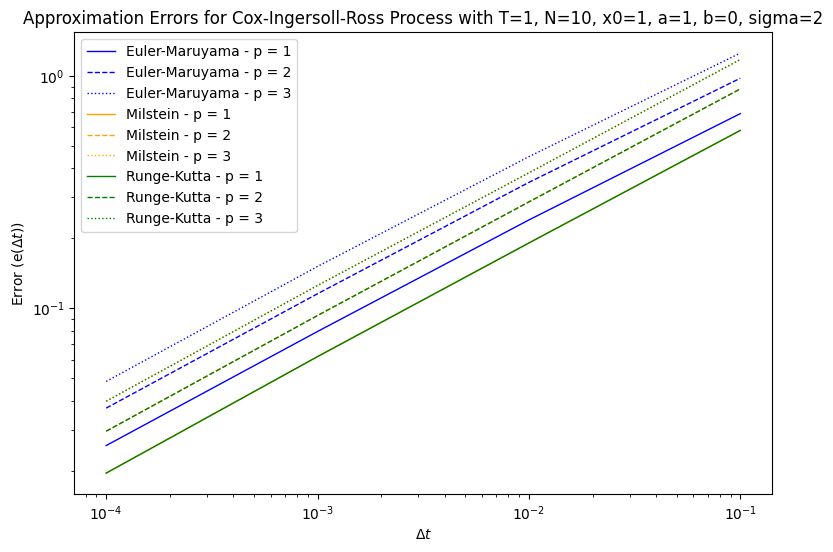

In [14]:
# Plot
delta_ts = dt_grid
colors = ['blue', 'orange', 'green']
for i, method_name in enumerate(APPROXIMATION_METHODS):
    plt.loglog(delta_ts, errors[p_values[0]][method_name], label=f"{method_name} - p = {p_values[0]}", color=colors[i])
    plt.loglog(delta_ts, errors[p_values[1]][method_name], label=f"{method_name} - p = {p_values[1]}", ls="--", color=colors[i])
    plt.loglog(delta_ts, errors[p_values[2]][method_name], label=f"{method_name} - p = {p_values[2]}", ls=":", color=colors[i])
plt.title(f'Approximation Errors for {sde}')
plt.xlabel('$\Delta t$')
plt.ylabel('Error (e($\Delta t$))')
plt.legend()

## Convergence rate

We are interested in strong $L^p$ convergence for $p\in [1, \infty)$, meaning we investigate the existence of an $\alpha \in (0, \infty)$ such that for all $p\in [1, \infty)$ there exists a constant $C\in (0, \infty)$ such that for the solution $X$ and approximation $Y$ of the SDE
$$ e_{\Delta t}(X, Y) \leq C \Delta t^\alpha\,. $$
For our simulation it means
$$ Err(\Delta t) \leq C \Delta t^\alpha\,. $$
Transforming the inequality we get
$$ \log(Err(\Delta t)) \leq \log(C) + \alpha \log(\Delta t)\,. $$
So we can estimate $\alpha$ by fitting a linear model to $\log(Err(\Delta t))$ and $\log(\Delta t)$

In [15]:
def calculate_convergence_rate(error_values, dts):
    """
    Calculate convergence rate from given errors and time discretizations.
    :param error_values: np.ndarray: errors of shape (num_dts). $Err(\Delta t)$ above
    :param dts: np.ndarray: time discretizations of shape (num_dts). $\Delta t$ above
    :return: float: convergence rate
    """
    x = np.log(dts).reshape(-1, 1)
    y = np.log(error_values)
    reg = LinearRegression().fit(x, y)
    return reg.coef_.item()

In [16]:
adapted_sde_name = str(sde).replace(f"N={sde.N}", f"N in {num_steps_grid}")
print(f'SDE: {sde}')
print("---")
for method_name in APPROXIMATION_METHODS:
    for p in p_values:
        covnergence_rate = calculate_convergence_rate(errors[p][method_name], delta_ts)
        print(f"{method_name} convergence rate for p = {p}: {covnergence_rate}")
    print("---")

SDE: Cox-Ingersoll-Ross Process with T=1, N=10, x0=1, a=1, b=0, sigma=2
---
Euler-Maruyama convergence rate for p = 1: 0.47655926936187776
Euler-Maruyama convergence rate for p = 2: 0.47384527477344035
Euler-Maruyama convergence rate for p = 3: 0.4711947001422666
---
Milstein convergence rate for p = 1: 0.49136331777922504
Milstein convergence rate for p = 2: 0.4908480718943066
Milstein convergence rate for p = 3: 0.48966938112193414
---
Runge-Kutta convergence rate for p = 1: 0.49136332036313757
Runge-Kutta convergence rate for p = 2: 0.4908480696555441
Runge-Kutta convergence rate for p = 3: 0.48966937638572855
---
